In [1]:
import os,random
os.environ["KERAS_BACKEND"] = "tensorflow"
os.environ["THEANO_FLAGS"]  = "device=gpu%d"%(1)
os.environ["MKL_THREADING_LAYER"] = "GNU"
import numpy as np
from keras.utils import np_utils
import keras.models as models
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.noise import GaussianNoise
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.regularizers import *
from keras.optimizers import adam
import random, sys, keras

Using TensorFlow backend.


In [20]:
from util import dataset_load

datafile_src = 'radio_data_2018Aug03_04_06.data'
#modelfile = 'QPSK.wts_model.h5'
[X_train_src, Y_train_src, X_test_src, Y_test_src] = dataset_load(datafile_src)

datafile_tar = 'radio_data_2018Aug03_04_10.data'
[X_train_tar, Y_train_tar, X_test_tar, Y_test_tar] = dataset_load(datafile_tar)

print('done')

done


In [28]:
import da_tool.tca
my_tca = da_tool.tca.TCA(dim=128,kerneltype='rbf', kernelparam=1, mu=1)
x_train_src_tca = np.zeros([10000,2,128])
x_train_tar_tca = np.zeros([10000,2,128])
x_test_src_tca = np.zeros([10000,2,128])
x_test_tar_tca = np.zeros([10000,2,128])

for i in range(0,len(X_train_src), 100):
    X_train_src_real = np.reshape(X_train_src[i:i+100,0,:], [100, 128])
    X_train_tar_real = np.reshape(X_train_tar[i:i+100,0,:], [100, 128])
    X_train_src_img = np.reshape(X_train_src[i:i+100,1,:], [100, 128])
    X_train_tar_img = np.reshape(X_train_tar[i:i+100,1,:], [100, 128])
    
    x_train_src_tca_real, x_train_tar_tca_real, _ = my_tca.fit_transform(X_train_src_real, X_train_tar_real)
    x_train_src_tca_img, x_train_tar_tca_img, _ = my_tca.fit_transform(X_train_src_img, X_train_tar_img)
    
    x_train_src_tca[i:i+100,0,:] = x_train_src_tca_real
    x_train_src_tca[i:i+100,1,:] = x_train_src_tca_img
    x_train_tar_tca[i:i+100,0,:] = x_train_src_tca_real
    x_train_tar_tca[i:i+100,1,:] = x_train_tar_tca_img
    
    #
    X_test_src_real = np.reshape(X_test_src[i:i+100,0,:], [100, 128])
    X_test_tar_real = np.reshape(X_test_tar[i:i+100,0,:], [100, 128])
    X_test_src_img = np.reshape(X_test_src[i:i+100,1,:], [100, 128])
    X_test_tar_img = np.reshape(X_test_tar[i:i+100,1,:], [100, 128])
    
    X_test_src_tca_real, X_test_tar_tca_real, _ = my_tca.fit_transform(X_test_src_real, X_test_tar_real)
    X_test_src_tca_img, X_test_tar_tca_img, _ = my_tca.fit_transform(X_test_src_img, X_test_tar_img)
    
    x_test_src_tca[i:i+100,0,:] = X_test_src_tca_real
    x_test_src_tca[i:i+100,1,:] = X_test_src_tca_img
    x_test_tar_tca[i:i+100,0,:] = X_test_tar_tca_real
    x_test_tar_tca[i:i+100,1,:] = X_test_tar_tca_img
    
print('done')

/usr/local/lib/python3.5/dist-packages/numpy/core/numeric.py:301: FutureWarning: in the future, full((100, 100), 1) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)


done


In [29]:
print(x_src_tca.shape)

(10000, 2, 128)


In [30]:
def deepsensing_network(in_shp = [2, 128], classes = ['busy' ,'idle']):
    K.set_image_dim_ordering('th')
    dr = 0.5
    model = models.Sequential()
    model.add(Reshape([1]+in_shp, input_shape=in_shp))
    model.add(ZeroPadding2D((0, 2)))
    model.add(Convolution2D(256, 1, 9, border_mode='valid', activation="relu", name="conv1", init='glorot_uniform'))
    model.add(Dropout(dr))
    model.add(ZeroPadding2D((0, 2)))
    model.add(Convolution2D(80, 2, 9, border_mode="valid", activation="relu", name="conv2", init='glorot_uniform'))
    model.add(Dropout(dr))
    model.add(Flatten())
    model.add(Dense(256, activation='relu', init='he_normal', name="dense1"))
    model.add(Dropout(dr))
    model.add(Dense( len(classes), init='he_normal', name="dense2" ))
    model.add(Activation('softmax'))
    model.add(Reshape([len(classes)]))
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    return model

In [32]:
from util import dataset_load

modelfile = 'QPSK.wts_model_tca.h5'

in_shp = [2,128]
classes = ['busy', 'idle']
batch_size = 1000
nb_epoch = 100

model = deepsensing_network(in_shp, classes)
     
history = model.fit(x_train_src_tca,
                    Y_train_src,
                    batch_size=batch_size,
                    nb_epoch=nb_epoch,
                    verbose=2,
                    validation_data=(x_test_src_tca, Y_test_src),
        callbacks = [
            keras.callbacks.ModelCheckpoint(modelfile, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
            keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
        ])

model.load_weights(modelfile)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (1, 9), kernel_initializer="glorot_uniform", padding="valid", name="conv1", activation="relu")`
  import sys
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(80, (2, 9), kernel_initializer="glorot_uniform", padding="valid", name="conv2", activation="relu")`
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(256, name="dense1", kernel_initializer="he_normal", activation="relu")`
  del sys.path[0]
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2, name="dense2", kernel_initializer="he_normal")`
  from ipykernel import kernelapp as app
/usr/local/lib/python3.5/di

Train on 10000 samples, validate on 10000 samples
Epoch 1/100
 - 3s - loss: 0.5031 - val_loss: 0.2341
Epoch 2/100
 - 1s - loss: 0.1403 - val_loss: 0.0545
Epoch 3/100
 - 1s - loss: 0.0442 - val_loss: 0.0185
Epoch 4/100
 - 1s - loss: 0.0217 - val_loss: 0.0261
Epoch 5/100
 - 1s - loss: 0.0180 - val_loss: 0.0126
Epoch 6/100
 - 1s - loss: 0.0166 - val_loss: 0.0188
Epoch 7/100
 - 1s - loss: 0.0129 - val_loss: 0.0180
Epoch 8/100
 - 1s - loss: 0.0169 - val_loss: 0.0179
Epoch 9/100
 - 1s - loss: 0.0136 - val_loss: 0.0058
Epoch 10/100
 - 1s - loss: 0.0133 - val_loss: 0.0067
Epoch 11/100
 - 1s - loss: 0.0109 - val_loss: 0.0142
Epoch 12/100
 - 1s - loss: 0.0104 - val_loss: 0.0050
Epoch 13/100
 - 1s - loss: 0.0110 - val_loss: 0.0097
Epoch 14/100
 - 1s - loss: 0.0096 - val_loss: 0.0088
Epoch 15/100
 - 1s - loss: 0.0101 - val_loss: 0.0031
Epoch 16/100
 - 1s - loss: 0.0114 - val_loss: 0.0043
Epoch 17/100
 - 1s - loss: 0.0096 - val_loss: 0.0029
Epoch 18/100
 - 1s - loss: 0.0114 - val_loss: 0.0059
Epoch

1.0 1.0


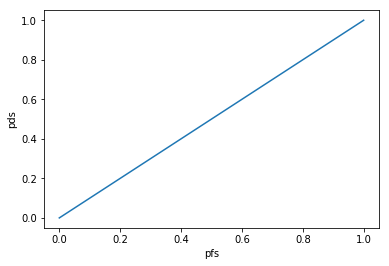

In [35]:
from util import  cal_roc, plot_roc, cal_pd_pf
import matplotlib.pyplot as plt

test_Y_hat = model.predict(x_test_tar_tca, batch_size=1000)

pd, pf = cal_pd_pf(x_test_tar_tca, Y_test_tar, test_Y_hat)
print(pd, pf)

pds, pfs = cal_roc(x_test_tar_tca, Y_test_tar, test_Y_hat)

plt.plot( pfs, pds)
plt.xlabel('pfs')
plt.ylabel('pds')
plt.show()

In [36]:
print(pfs)
print(pds)

[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0

In [ ]:
from util import dataset_load

datafile = 'radio_data_2018Aug03_03_46.data'
modelfile = 'QPSK.wts_model.h5'

[X_train, Y_train, X_test, Y_test] = dataset_load(datafile)

in_shp = [2,128]
classes = ['busy', 'idle']
batch_size = 1000
nb_epoch = 100

model = deepsensing_network(in_shp, classes)
     
history = model.fit(X_train,
                    Y_train,
                    batch_size=batch_size,
                    nb_epoch=nb_epoch,
                    verbose=2,
                    validation_data=(X_test, Y_test),
        callbacks = [
            keras.callbacks.ModelCheckpoint(modelfile, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
            keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
        ])

model.load_weights(modelfile)

In [ ]:
from util import  cal_roc, plot_roc, cal_pd_pf
import matplotlib.pyplot as plt

datafile = 'radio_data_2018Aug03_04_10.data'

[X_train, Y_train, X_test, Y_test] = dataset_load(datafile)

test_Y_hat = model.predict(X_test, batch_size=1000)

pd, pf = cal_pd_pf(X_test, Y_test, test_Y_hat)
print(pd, pf)

pds, pfs = cal_roc(X_test, Y_test, test_Y_hat)

plt.plot( pfs, pds)
plt.xlabel('pfs')
plt.ylabel('pds')
plt.show()

In [ ]:
import da_tool.tca
my_tca = da_tool.tca.TCA(dim=30,kerneltype='rbf', kernelparam=1, mu=1)
x_src_tca, x_tar_tca, x_tar_o_tca = my_tca.fit_transform(X_test, X_test_new)